In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Paths to the dataset
data_dir = "C:/Users/PC/Desktop/CCN_MODEL_training/AffectNet"
labels_file = os.path.join(data_dir, "labels.csv")

# Load labels from the CSV file
labels_df = pd.read_csv(labels_file)

# Define the emotions in the dataset (excluding 'contempt')
emotions = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotion_to_label = {emotion: idx for idx, emotion in enumerate(emotions)}

# Filter out rows with the 'contempt' label
labels_df = labels_df[~labels_df['label'].isin(['contempt'])]

# Function to load images and match them with labels
def load_images_and_labels(data_dir, labels_df, img_size=(96, 96)):
    images = []
    labels = []
    for _, row in labels_df.iterrows():
        img_path = os.path.join(data_dir, row['pth'])
        label = row['label']
        
        if label in emotion_to_label and os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(emotion_to_label[label])
        else:
            print(f"Skipping image: {img_path} or invalid label: {label}")
    
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(data_dir, labels_df)

# Normalize images and expand dimensions
images = images / 255.0
images = np.expand_dims(images, axis=-1)

# Convert labels to one-hot encoding
num_classes = len(emotions)
labels = to_categorical(labels, num_classes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

model=load_model("affectnet_model_best.keras")

# Evaluate model accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.2f}")





Training data shape: (19944, 96, 96, 1), (19944, 7)
Testing data shape: (4987, 96, 96, 1), (4987, 7)
156/156 - 10s - 67ms/step - accuracy: 0.6647 - loss: 2.5364
Test Accuracy: 0.66


c:\Users\PC\anaconda3\envs\FYP_HMK\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total Accuracy on AffectNet dataset: 0.57


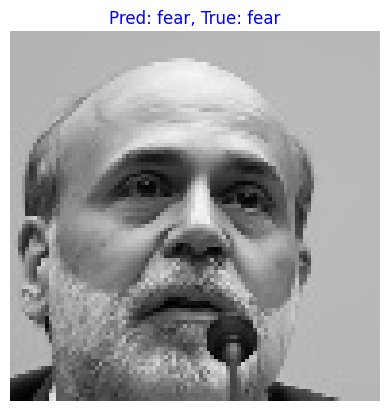

In [1]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import numpy as np
import cv2
import pandas as pd
import os
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths to the dataset
data_dir = "C:/Users/PC/Desktop/CCN_MODEL_training/AffectNet"
labels_file = os.path.join(data_dir, "labels.csv")

# Load labels from the CSV file
labels_df = pd.read_csv(labels_file)

# Define the emotions in the dataset (excluding 'contempt')
emotions = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotion_to_label = {emotion: idx for idx, emotion in enumerate(emotions)}

# Filter out rows with the 'contempt' label
labels_df = labels_df[~labels_df['label'].isin(['contempt'])]

# Function to load images and match them with labels
def load_images_and_labels(data_dir, labels_df, img_size=(96, 96)):
    images = []
    labels = []
    for _, row in labels_df.iterrows():
        img_path = os.path.join(data_dir, row['pth'])
        label = row['label']
        
        if label in emotion_to_label and os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
            img = cv2.resize(img, img_size)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
            images.append(img_rgb)
            labels.append(emotion_to_label[label])
        else:
            print(f"Skipping image: {img_path} or invalid label: {label}")
    
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(data_dir, labels_df)

# Normalize images and expand dimensions
images = images / 255.0

# Convert labels to one-hot encoding
num_classes = len(emotions)
labels = to_categorical(labels, num_classes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the pre-trained model and processor
processor = AutoImageProcessor.from_pretrained("motheecreator/vit-Facial-Expression-Recognition")
model = AutoModelForImageClassification.from_pretrained("motheecreator/vit-Facial-Expression-Recognition")

# Preprocessing the images for ViT
transform = Compose([
    ToPILImage(),                          # Convert NumPy array to PIL Image
    Resize((224, 224)),                     # Resize to 224x224 to match ViT input size
    ToTensor(),                             # Convert to PyTorch tensor
    Normalize(mean=processor.image_mean,    # Normalize with ViT's pre-trained mean and std
              std=processor.image_std)
])

# Preprocess the images
processed_data = torch.stack([transform(image) for image in X_test])  # Use X_test here

# Make predictions with the model
model.eval()
with torch.no_grad():
    predictions = model(processed_data).logits
    predicted_labels = torch.argmax(predictions, dim=1).numpy()

# Calculate accuracy
correct_predictions = (predicted_labels == np.argmax(y_test, axis=1))  # Compare to one-hot encoded labels
accuracy = correct_predictions.sum() / len(y_test)

# Print total accuracy
print(f"Total Accuracy on AffectNet dataset: {accuracy:.2f}")

# Visualize a few predictions
def plot_image(i, predictions, true_labels, images, class_names):
    pred_label = predictions[i]
    true_label = true_labels[i]
    image = images[i]

    # Determine color based on correctness
    color = 'blue' if pred_label == true_label else 'red'

    # Display the image
    plt.imshow(image)
    plt.title(f"Pred: {class_names[pred_label]}, True: {class_names[true_label]}", color=color)
    plt.axis('off')

# Plot example (you can change the index 'i' to visualize a different image)
i = 0  # Index of the image to visualize
plot_image(i, predicted_labels, np.argmax(y_test, axis=1), X_test, emotions)
plt.show()
